In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import time
import re
import numpy as np
import nltk
import requests
import random
from collections import defaultdict
from bs4 import BeautifulSoup
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [2]:
class WebScrapper(BeautifulSoup):
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/119.0.0.0 Safari/537.36 Edg/119.0.0.0',
               'Connection':'close'}

    def __init__(self, url, **kwargs):
        
        time.sleep(np.random.randint(10, high=16))
        
        resp = requests.get(url, headers=self.headers)
        assert resp.status_code==200, f"req not successfull: {resp.status_code}"
        super().__init__(resp.content, "html.parser", **kwargs)
        

    def extract(self, name=None, attrs={}, **kwargs):
        content = super().find(name=name, attrs=attrs, **kwargs).find_all('p')

        texts = []
        for par in content:
            texts.append(par.get_text())
        extracted_text = " ".join(texts)

        return extracted_text

In [ ]:
days = np.arange(1,32)
dates = [f'2023-10-{d:02d}' for d in days]
dates.append('2023-11-01')

companies = ["VISA Inc", "UnitedHealth Group Inc", "Verizon Communications Inc", "Adobe Inc"]

# Define the URL of the articles on Yahoo.com
_dict = defaultdict(list)

for company in companies:
    print(f'{company}:', end='')
    
    for j in range(len(dates) - 1):
        url = f"https://www.google.com/search?q={company} site:yahoo.com after:{dates[j]} before:{dates[j+1]} -AVI -FLV -WMV -MOV -MP4 -jpg -jpeg -png"
        
        ws = WebScrapper(url)
        links = ws.find_all("a")

        count = 0
        for link in links:
            try:
                if link['href'][:30] == 'https://finance.yahoo.com/news' or link['href'][:26] == 'https://www.yahoo.com/news':
                    _dict[(company, dates[j])].append(link["href"])
                    count += 1
                if count == 2: # number of articles
                    break
            except:
                pass
        print('.', end='')
    print('')
np.save('links_new.npy', _dict)

    
    
results = {}
for k, v in _dict.items():
    
    for url in v:
        
        ws = WebScrapper(url)
        text = ws.extract('div', class_='caas-body')
        
        sia = SentimentIntensityAnalyzer()
        scores = sia.polarity_scores(text)
        
        if k in results:
            for name, score in scores.items():
                results[k][name] += score
                results[k][name] /= 2
                results[k][name] = round(results[k][name], 4)
        else:
            results[k] = scores
        time.sleep(5)
    print('.', end='')    
    
df = pd.DataFrame.from_dict(results, orient='index')
df.to_csv('sentiment_scores_mehdi.csv')    

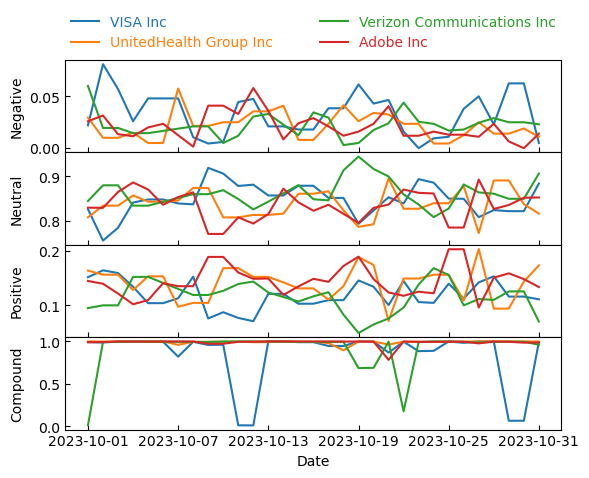

In [127]:
columns = ['Negative', 'Neutral', 'Positive', 'Compound']
fg, ax = plt.subplots(nrows=4, sharex=True)

for col in range(df.shape[1]):
    
    for c, company in enumerate(companies):

        # select rows
        list_ix = []
        list_dates = []
        for i, ix in enumerate(df.index):
            if ix[0]==company:
                list_ix.append(i)
                list_dates.append(ix[1])

        ax[col].plot(list_dates, df.iloc[list_ix, col], label=company)

    ax[col].set_ylabel(columns[col])
    ax[col].tick_params(direction='in', which='both')
    
ax[-1].set_xlabel('Date')
ax[0].xaxis.set_major_locator(plt.MaxNLocator(6))
lg = ax[0].legend(ncol=2, frameon=False,
                  bbox_to_anchor=(0, 1.05, 1, 0.4), loc="lower left",
                  mode="expand", borderaxespad=0)

for i, tx in enumerate(lg.get_texts()):
    tx.set_color('C%d'%i)

fg.subplots_adjust(hspace=0.0)
fg.align_labels()

In [111]:
sia = SentimentIntensityAnalyzer()

In [122]:
sia.polarity_scores("I like this dog.")

{'neg': 0.0, 'neu': 0.444, 'pos': 0.556, 'compound': 0.3612}

In [113]:
sia.polarity_scores("I love this dog.")

{'neg': 0.0, 'neu': 0.323, 'pos': 0.677, 'compound': 0.6369}

In [114]:
sia.polarity_scores("I hate this dog.")

{'neg': 0.649, 'neu': 0.351, 'pos': 0.0, 'compound': -0.5719}

In [123]:
sia.polarity_scores("I love this dog, but she makes a lot of mess.")

{'neg': 0.253, 'neu': 0.545, 'pos': 0.202, 'compound': -0.1655}